In [1]:
import pandas as pd
import numpy as np
from typing import Optional
from geopy.distance import distance as geodistance # to dompute geodesic distance between points on the sphere
from matplotlib import pyplot as plt

# Load data

In [2]:
# !git clone https://github.com/hflabs/city.git 

In [3]:
data = pd.read_csv("city/city.csv")

In [4]:
data30 = data.sort_values(by='population', ascending=False).iloc[:30]

# Simulated annealing algorithm

In [5]:
def mutate_path(path: list[int]) -> list[int]:
    """Simple mutation of the path; swaps two random cities in the path"""
    indeces_to_swap = np.random.choice(list(range(len(path))), size=2, replace=False)
    idx1, idx2 = indeces_to_swap
    new_path = path.copy()
    new_path[idx1] = path[idx2]
    new_path[idx2] = path[idx1]
    return new_path

In [6]:
def compute_path_distance(path: list[int]) -> float:
    """computes the summary distance of the path, i.e. the score of the solution
    (less score is better)
    """
    cumulative_distance = 0
    for idx in range(len(path) - 1):
        point1idx = path[idx]
        point2idx = path[idx + 1]
        cumulative_distance += geodistance(
            data30[['geo_lat', 'geo_lon']].iloc[point1idx],
            data30[['geo_lat', 'geo_lon']].iloc[point2idx],
        ).km
    return cumulative_distance

In [7]:
def compute_acceptance_ratio(quality_candidate: float, quality_current: float, temp: float) -> float:
    """Computes acceptance ratio
    
    I slightly changed the formula from the assignment to decrease inaccuracy 
    due to floating point number specifics. The formula gives the same answer but
    is computed differently
    """
    return np.exp((-quality_candidate + quality_current)/temp, dtype=np.float128) 

In [8]:
N_ITERATIONS = 1000
def run_simulated_annealing(temp_multiplier: float, n_iterations: float = N_ITERATIONS, verbosity: Optional[float] = None):
    """Run simulated annealing and find the optimal path"""
    current_path = list(range(30)) # initial solution is just from 0th to 29th city
    temp = 10000 # initial temperature is high enough
    min_temp = 1 # value to clip min temperature, because temp~0.0001 may lead to
                 # numerical problems. Min temp = 1 is low enough to be considered "very cool"
    current_path_quality = compute_path_distance(current_path)
    score_history = []
    for iteration in range(N_ITERATIONS):
        # here the algorithm goes straightforward as the tutorial says
        candidate_path = mutate_path(current_path)
        candidate_path_quality = compute_path_distance(candidate_path)
        acceptance_ratio = compute_acceptance_ratio(candidate_path_quality, current_path_quality, temp)
        u = np.random.uniform(0, 1)
        if u < acceptance_ratio: 
            current_path = candidate_path
            current_path_quality = candidate_path_quality
        # reduce temperature
        temp = max(temp_multiplier * temp, min_temp)
        # this one is for logging
        if verbosity is not None and iteration % verbosity == 0:
            print(f"Iteration {iteration:5d}, temperature {temp:8.1f}: current path distance: {current_path_quality:6.2f}")
        score_history.append(current_path_quality)
    return current_path, score_history

# Experiments on performance for different temperature multipliers

In [9]:
path, quality = run_simulated_annealing(temp_multiplier=0.99, verbosity=100)

Iteration     0, temperature  10000.0: current path distance: 62273.28
Iteration   100, temperature   3660.3: current path distance: 48346.97
Iteration   200, temperature   1339.8: current path distance: 39505.61
Iteration   300, temperature    490.4: current path distance: 29842.29
Iteration   400, temperature    179.5: current path distance: 25638.80
Iteration   500, temperature     65.7: current path distance: 23994.51
Iteration   600, temperature     24.1: current path distance: 22677.36
Iteration   700, temperature      8.8: current path distance: 22147.00
Iteration   800, temperature      3.2: current path distance: 20915.31
Iteration   900, temperature      1.2: current path distance: 19967.04


In [12]:
N_TRIALS = 3
temperature_multipliers = [0.7, 0.9, 0.99, 0.999]
results = []

for temperature_multiplier in temperature_multipliers:
    print(f"Temperature multiplier {temperature_multiplier}")
    print("-"*30)
    multiplier_results = []
    for trial in range(N_TRIALS):
        print(f"Trial {trial}")
        path, distance_history = run_simulated_annealing(temperature_multiplier, verbosity=333)
        multiplier_results.append(distance_history[-1])
    results.append({
        "temperature_multiplier": temperature_multiplier,
        "best_score": np.min(multiplier_results), 
        "median_score": np.median(multiplier_results),
        "mean_score": np.mean(multiplier_results),
    })
results_df = pd.DataFrame(results)

Temperature multiplier 0.7
------------------------------
Trial 0
Iteration     0, temperature  10000.0: current path distance: 62719.05
Iteration   333, temperature      1.0: current path distance: 24306.55
Iteration   666, temperature      1.0: current path distance: 20752.25
Iteration   999, temperature      1.0: current path distance: 20190.02
Trial 1
Iteration     0, temperature  10000.0: current path distance: 61958.42
Iteration   333, temperature      1.0: current path distance: 22908.62
Iteration   666, temperature      1.0: current path distance: 22004.61
Iteration   999, temperature      1.0: current path distance: 20339.12
Trial 2
Iteration     0, temperature  10000.0: current path distance: 62728.69
Iteration   333, temperature      1.0: current path distance: 26184.60
Iteration   666, temperature      1.0: current path distance: 23330.73
Iteration   999, temperature      1.0: current path distance: 22020.72
Temperature multiplier 0.9
------------------------------
Trial 0


In [13]:
results_df

,temperature_multiplier,best_score,median_score,mean_score
0,0.700,20190.015001,20339.124316,20849.953116
1,0.900,19109.747180,20081.867383,21018.323744
2,0.990,16349.655102,21240.636830,20467.570010
3,0.999,44668.345960,52494.908435,51064.943781


# Experiment on convergence

In [14]:
temperature_multipliers = [0.7, 0.9, 0.99, 0.999]
convergences = []

for temperature_multiplier in temperature_multipliers:
    path, distance_history = run_simulated_annealing(temperature_multiplier, verbosity=499)
    convergences.append(distance_history)

Iteration     0, temperature  10000.0: current path distance: 63774.16
Iteration   499, temperature      1.0: current path distance: 23298.21
Iteration   998, temperature      1.0: current path distance: 19674.14
Iteration     0, temperature  10000.0: current path distance: 58708.59
Iteration   499, temperature      1.0: current path distance: 27324.53
Iteration   998, temperature      1.0: current path distance: 24288.43
Iteration     0, temperature  10000.0: current path distance: 62376.46
Iteration   499, temperature     66.4: current path distance: 29533.44
Iteration   998, temperature      1.0: current path distance: 20009.83
Iteration     0, temperature  10000.0: current path distance: 61958.42
Iteration   499, temperature   6069.9: current path distance: 70514.79
Iteration   998, temperature   3684.3: current path distance: 52896.99


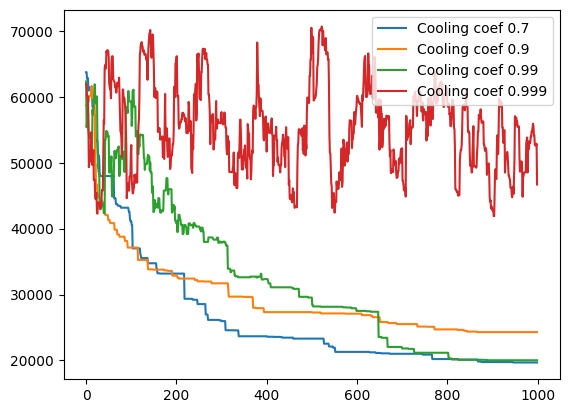

In [15]:
for convergence in convergences:
    plt.plot(convergence)
plt.legend([f"Cooling coef {coef}" for coef in temperature_multipliers])
plt.show()

# Report

The coefficient 0.99 was found to be the best choice, producing the shortest path length on average. The coefficients 0.7 and 0.9 also gave comparable results, but were slightly worse than 0.99. The coefficient 0.999 performed very poorly, with almost no improvement over the initial random path.

The results of the experiment are consistent with the theoretical properties of the SA algorithm. A high temperature multiplier coefficient (i.e., close to 1) leads to a slower decrease in temperature, which allows the algorithm to explore the search space more thoroughly. However, this also increases the probability of accepting worse solutions, which can lead to a slower convergence towards the optimal solution. That is why coefficient 0.99 performs better, than the lower ones, though converges more slowly.

The coefficient 0.999 performed very poorly, indicating that a very slow decrease in temperature may be detrimental to the performance of the algorithm. Apparently, that cooling coefficient is so high, that during the specified amount of iterations (1000 iterations) it does manage to reduce the temperature enough to reject bad candidate paths. 

# Visualization

In [16]:
N_ITERATIONS = 3000
current_path = list(range(30))
temp = 10000
min_temp = 1
temp_multiplier = 0.95
current_path_quality = compute_path_distance(current_path)
path_history = [current_path]
score_history = [current_path_quality]

for iteration in range(N_ITERATIONS):
    candidate_path = mutate_path(current_path)
    candidate_path_quality = compute_path_distance(candidate_path)
    acceptance_ratio = compute_acceptance_ratio(candidate_path_quality, current_path_quality, temp)
    u = np.random.uniform(0, 1)
    if u < acceptance_ratio: 
        current_path = candidate_path
        current_path_quality = candidate_path_quality
        path_history.append(current_path)
        score_history.append(current_path_quality)
    temp = max(temp_multiplier * temp, min_temp)

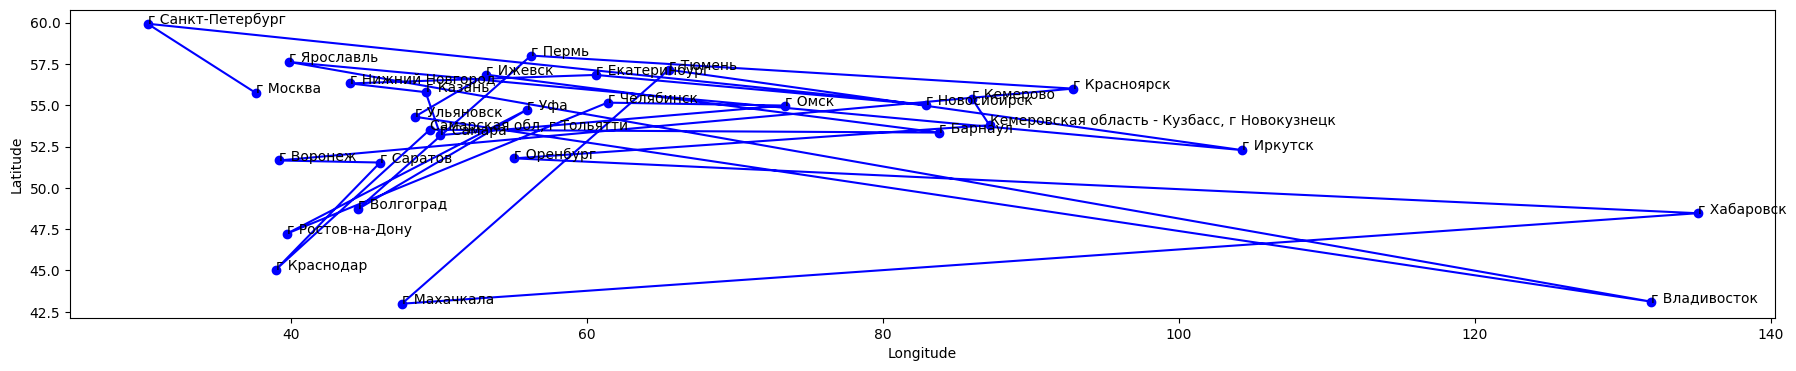

In [17]:
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(22, 4))

def animate(path):
    plt.clf()
    coordinates = data30[['geo_lat', 'geo_lon']].iloc[path]
    plt.scatter(coordinates.geo_lon, coordinates.geo_lat, c='b')
    plt.plot(coordinates.geo_lon, coordinates.geo_lat, c='b')
    for city_idx in range(len(data30)):
        plt.annotate(data30.iloc[city_idx].address, (data30.iloc[city_idx].geo_lon, data30.iloc[city_idx].geo_lat))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

ani = FuncAnimation(fig, animate, frames=path_history, interval=300, blit=False)
ani.save('hello.gif', fps=10)  